In [7]:
!pip install keras
!pip install librosa
!pip install imutils
!pip install seaborn
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=b1da73e27c2731fbbe26633111da34d3086d8e0d391332924c01864b761f478f
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 29.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
ER

In [8]:
!sudo apt-get install libsndfile1 -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7ubuntu0.1).
libsndfile1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 112 not upgraded.


In [2]:
import time
import keras
import random
import pickle
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from keras.models import load_model
from matplotlib.pyplot import figure
from keras.layers import Input, Dense
from sklearn.decomposition import FastICA
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Flatten
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
model = keras.models.Sequential()
model.add(Dense(8192, activation='relu', input_shape=(193,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

2023-01-07 16:43:36.651834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


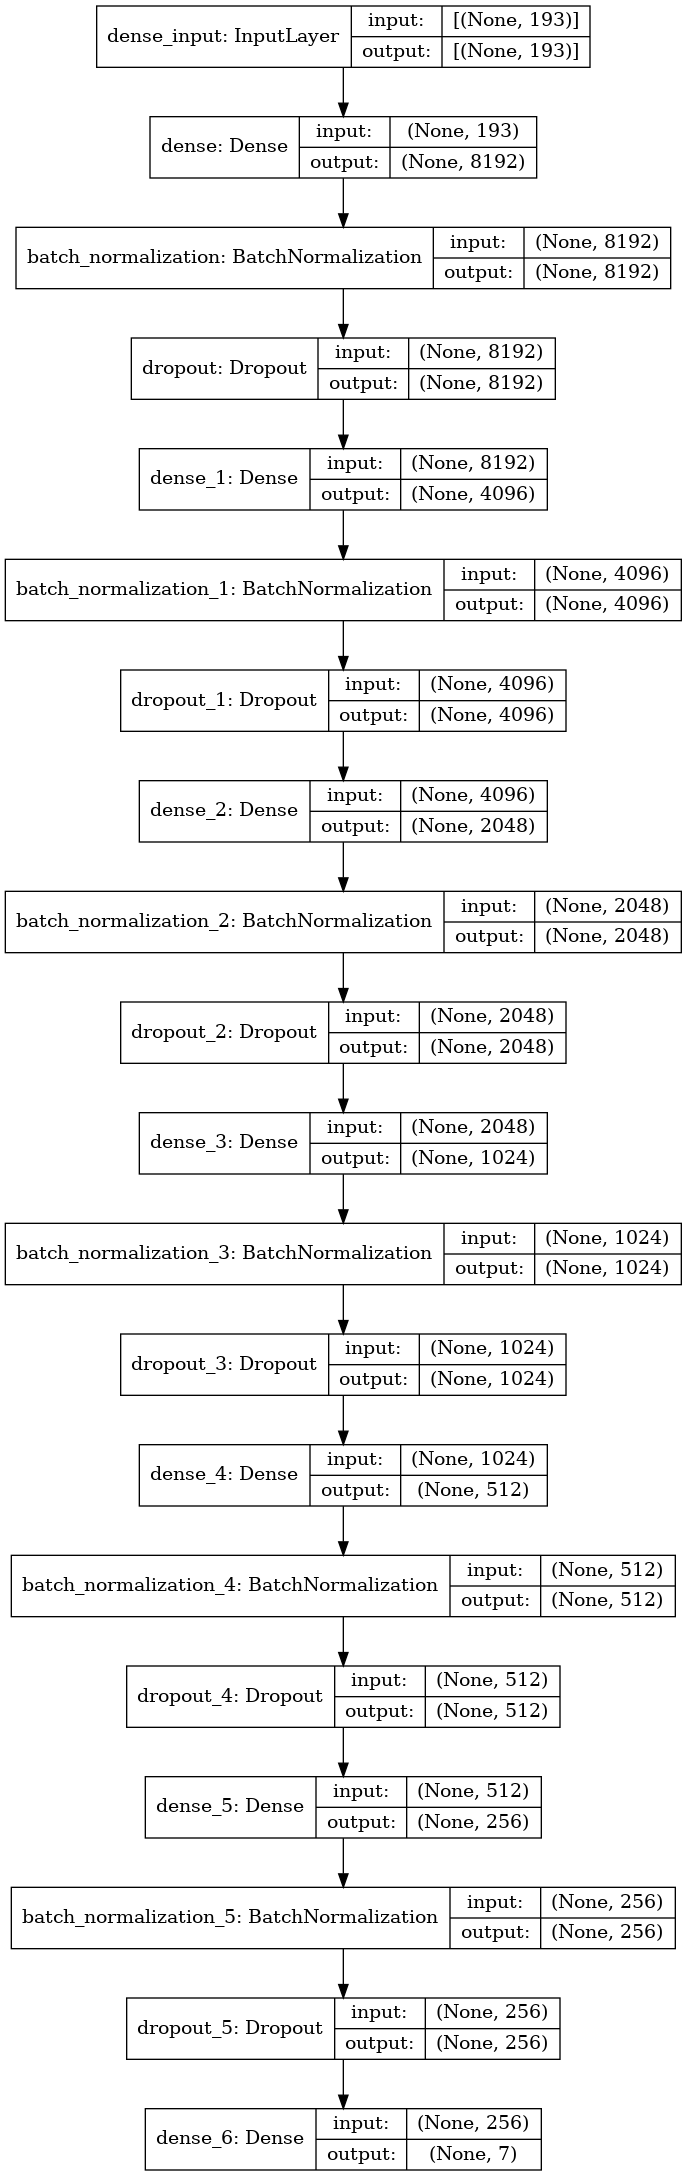

In [6]:
dot_img_file = '/kaggle/working/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [41]:
# to generate Confusion Matrix
def ConfusionMatrix(Y_Actual, Y_Pred):
    CF = confusion_matrix(Y_Actual, Y_Pred)
    return CF

# to Plot Confusion Matrix
def PLOT_ConfusionMatrix(CF,Title):
    sns.heatmap(CF, annot=True, fmt='d')
    plt.title(Title, fontsize = 15)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)
    return plt.show()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# get the each class records in list of lists
def GetListOfClasses(numberOfClasses, DataSet, TargetColumn):
        ls = [None] * numberOfClasses
        for i in range(0,numberOfClasses):
            ls[i] = DataSet.loc[DataSet[TargetColumn] == i]
        return ls

# Plot Data Points
def PlotDataPoints(numberOfClasses,colorsOpt ,ListOFClasses, XLabel, Ylabel ,labels ,S, Title):
    MarkersOptions = ['o']
    
    for i in range(numberOfClasses):
        plt.scatter(x = ListOFClasses[i].iloc[:, 0:1], y = ListOFClasses[i].iloc[:, 1:2], c=colorsOpt[i], marker = MarkersOptions[0], s=S, label = labels[i])

    plt.xlabel(XLabel, fontsize = 15)
    plt.ylabel(Ylabel, fontsize = 15)
    plt.title(Title)
    plt.legend()
    return plt

accurices = []
###########################################################################

In [48]:
df = pd.read_csv("/kaggle/input/hosamdataset/Splited_Sampel_Data.csv")
print(df["SetType"].unique())
train_idx = df[df["SetType"]=="train"].index
test_idx = df[df["SetType"]=="test"].index
val_idx = df[df["SetType"]=="valid"].index
print("Train: ",len(train_idx))
print("Test: ",len(test_idx))
print("Validation: ",len(val_idx))

['test' 'train' 'valid']
Train:  265995
Test:  33249
Validation:  33250


In [49]:
x = pd.read_csv("/kaggle/input/hosam-dataset/x_feature_vector_Final.csv")
y = pd.read_csv("/kaggle/input/hosam-dataset/Y_Final.csv")

x_train = x.iloc[train_idx,:].reset_index(drop=True).to_numpy()
y_train = y.iloc[train_idx,:].reset_index(drop=True).to_numpy().reshape(-1)

x_test = x.iloc[test_idx,:].reset_index(drop=True).to_numpy()
y_test = y.iloc[test_idx,:].reset_index(drop=True).to_numpy().reshape(-1)

x_val = x.iloc[val_idx,:].reset_index(drop=True).to_numpy()
y_val = y.iloc[val_idx,:].reset_index(drop=True).to_numpy().reshape(-1)

x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
x_val, y_val = shuffle(x_val, y_val)

In [50]:
print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

print(len(x_val))
print(len(y_val))

265995
265995
33249
33249
33250
33250


In [8]:
colorsOptions = []
Labels = []
letters = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f"]
for j in range(7):
    Labels.append(j)
    colorsOptions.append(''.join(random.choice(letters) for i in range(6)))
    colorsOptions[j] = '#' + colorsOptions[j]

In [9]:
colorsOptions

['#d26b71', '#5a0cc4', '#b676bc', '#26790e', '#69b45b', '#c46081', '#a7e20b']

In [7]:
x_val

array([[-1.30661438e+02,  8.40166779e+01,  1.96866341e+01, ...,
        -4.48468657e-03, -1.97410904e-02,  2.30702134e-02],
       [-5.70609253e+02,  4.48133850e+01,  1.47860222e+01, ...,
        -1.37864552e-03,  2.74938692e-02,  1.13698552e-02],
       [-3.91225800e+02,  7.57421646e+01,  8.29479599e+00, ...,
        -5.56868541e-02,  2.13005870e-02,  7.15491401e-03],
       ...,
       [-4.47370636e+02,  1.25478363e+02,  1.48036222e+01, ...,
        -3.60281825e-02,  2.45775210e-02, -5.60245675e-03],
       [-5.61761597e+02,  7.73218918e+01,  1.12241488e+01, ...,
         3.22475828e-02,  2.94470765e-02, -4.49641696e-02],
       [-4.69588257e+02,  1.08911461e+02, -1.58340244e+01, ...,
         3.11703007e-02,  3.59826690e-03, -1.16846615e-02]])

In [8]:
y_val

array([2, 5, 4, ..., 0, 6, 3])

In [12]:
x_tsne = TSNE(n_components=2).fit_transform(x_val)

tsne_features = pd.concat([pd.DataFrame(x_tsne).reset_index(drop=True), pd.DataFrame(y_val).reset_index(drop=True)],axis=1 , ignore_index = True).astype(float)
listOfclasses = GetListOfClasses(7, tsne_features , pd.DataFrame(tsne_features).columns[2])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


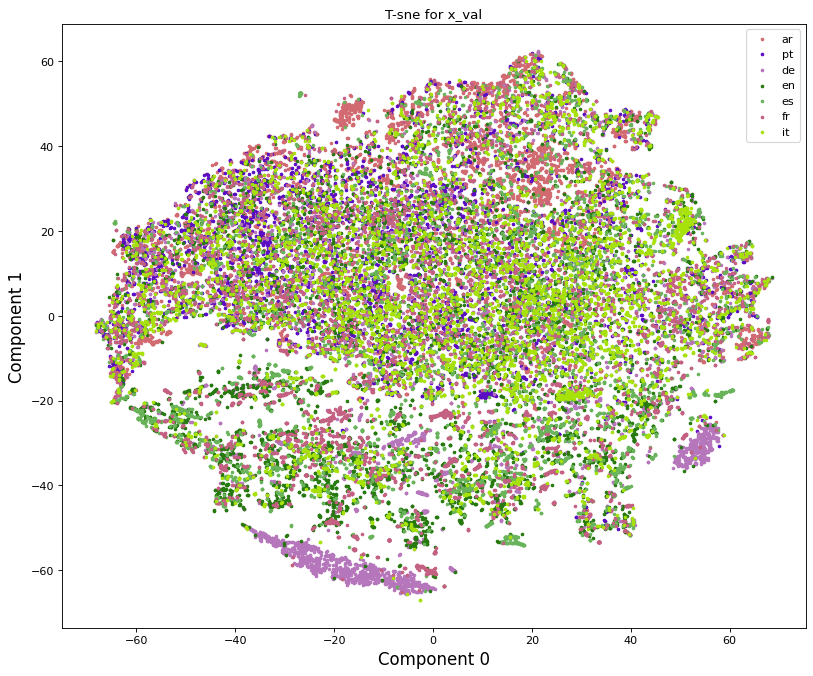

In [13]:
figure(figsize=(12, 10), dpi=80)
PlotDataPoints(7, colorsOptions, listOfclasses, 'Component 0', 'Component 1' ,['ar', 'pt', 'de', 'en', 'es', 'fr', 'it'] ,5, 'T-sne for x_val').show()

2023-01-06 15:55:48.855509: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
3244/3244 [==============================] - 41s 12ms/step - loss: 1.5138 - accuracy: 0.4323 - val_loss: 1.3502 - val_accuracy: 0.4871
Epoch 2/1000
3244/3244 [==============================] - 37s 11ms/step - loss: 1.3217 - accuracy: 0.5052 - val_loss: 1.2419 - val_accuracy: 0.5327
Epoch 3/1000
3244/3244 [==============================] - 37s 11ms/step - loss: 1.2384 - accuracy: 0.5391 - val_loss: 1.1785 - val_accuracy: 0.5692
Epoch 4/1000
3244/3244 [==============================] - 37s 11ms/step - loss: 1.1699 - accuracy: 0.5656 - val_loss: 1.2453 - val_accuracy: 0.5359
Epoch 5/1000
3244/3244 [==============================] - 37s 11ms/step - loss: 1.1185 - accuracy: 0.5875 - val_loss: 1.0739 - val_accuracy: 0.6089
Epoch 6/1000
3244/3244 [==============================] - 37s 11ms/step - loss: 1.0810 - accuracy: 0.6018 - val_loss: 1.1280 - val_accuracy: 0.5854
Epoch 7/1000
3244/3244 [==============================] - 37s 11ms/step - loss: 1.0464 - accuracy: 0.6158 - val_

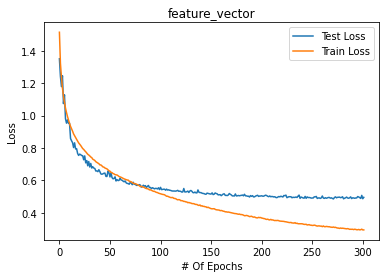

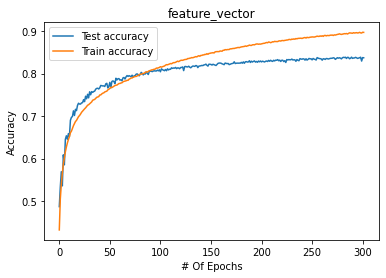

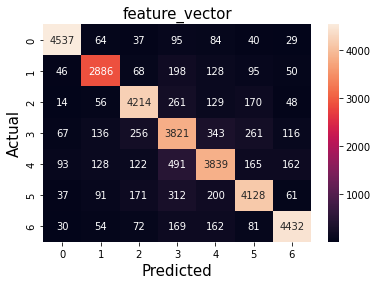

              precision    recall  f1-score   support

          ar       0.94      0.93      0.93      4886
          pt       0.85      0.83      0.84      3471
          de       0.85      0.86      0.86      4892
          en       0.71      0.76      0.74      5000
          es       0.79      0.77      0.78      5000
          fr       0.84      0.83      0.83      5000
          it       0.90      0.89      0.90      5000

    accuracy                           0.84     33249
   macro avg       0.84      0.84      0.84     33249
weighted avg       0.84      0.84      0.84     33249



In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

obj_ICA = FastICA(tol=0.2)
x_train = obj_ICA.fit_transform(x_train)
x_test = obj_ICA.transform(x_test)
x_val = obj_ICA.transform(x_val)

model = keras.models.Sequential()
model.add(Dense(8192, activation='relu', input_shape=(193,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=1000, batch_size = 82, validation_data=(x_val, y_val), callbacks=es)

loss_training = history.history['loss']
loss_test = history.history['val_loss']

accuracy_training = history.history['accuracy']
accuracy_test = history.history['val_accuracy']

plt.plot(loss_test)
plt.plot(loss_training)
plt.xlabel("# Of Epochs")
plt.ylabel("Loss")
plt.legend(['Test Loss', 'Train Loss'])
plt.title("feature_vector")
plt.show()

plt.plot(accuracy_test)
plt.plot(accuracy_training)
plt.xlabel("# Of Epochs")
plt.ylabel("Accuracy")
plt.legend(['Test accuracy', 'Train accuracy'])
plt.title("feature_vector")
plt.show()

y_pred = np.argmax(model.predict(x_test), axis=1)
cm = ConfusionMatrix(y_test, y_pred)
PLOT_ConfusionMatrix(cm,"feature_vector")
accurices.append(accuracy_score(y_test,y_pred))
report_feature_vector = classification_report(y_test, y_pred, target_names = ['ar', 'pt', 'de', 'en', 'es', 'fr', 'it'])
print(report_feature_vector)
model.save("Deep_Signal_model.h5")

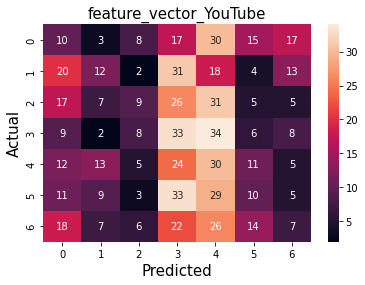

              precision    recall  f1-score   support

          ar       0.10      0.10      0.10       100
          pt       0.23      0.12      0.16       100
          de       0.22      0.09      0.13       100
          en       0.18      0.33      0.23       100
          es       0.15      0.30      0.20       100
          fr       0.15      0.10      0.12       100
          it       0.12      0.07      0.09       100

    accuracy                           0.16       700
   macro avg       0.16      0.16      0.15       700
weighted avg       0.16      0.16      0.15       700



In [32]:
x_YT_test = pd.read_csv("/kaggle/input/yt-dataset/x_feature_vector_YT.csv")
y_YT_test = pd.read_csv("/kaggle/input/yt-dataset/y_YT.csv")

x_YT_test, y_YT_test = shuffle(x_YT_test, y_YT_test)

x_YT_test = x_YT_test.reset_index(drop=True).to_numpy()
y_YT_test = y_YT_test.reset_index(drop=True).to_numpy().reshape(-1)

scaler = StandardScaler()
x_YT_test = scaler.fit_transform(x_YT_test)

obj_ICA = FastICA(tol=0.2)
x_YT_test = obj_ICA.fit_transform(x_YT_test)

model = keras.models,load_model("/kaggle/working/Deep_Signal_model.h5")
model[1].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_pred = np.argmax(model[1].predict(x_YT_test), axis=1)
cm = ConfusionMatrix(y_YT_test, y_pred)
PLOT_ConfusionMatrix(cm,"feature_vector_YouTube")
report_feature_vector = classification_report(y_YT_test, y_pred, target_names = ['ar', 'pt', 'de', 'en', 'es', 'fr', 'it'])
print(report_feature_vector)

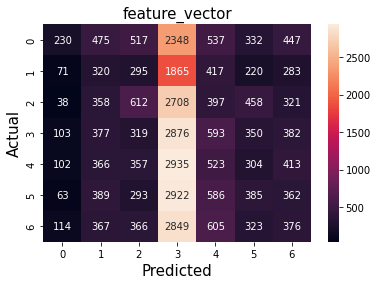

              precision    recall  f1-score   support

          ar       0.32      0.05      0.08      4886
          pt       0.12      0.09      0.10      3471
          de       0.22      0.13      0.16      4892
          en       0.16      0.58      0.24      5000
          es       0.14      0.10      0.12      5000
          fr       0.16      0.08      0.10      5000
          it       0.15      0.08      0.10      5000

    accuracy                           0.16     33249
   macro avg       0.18      0.16      0.13     33249
weighted avg       0.18      0.16      0.13     33249



In [51]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

obj_ICA = FastICA(tol=0.2)
x_train = obj_ICA.fit_transform(x_train)
x_test = obj_ICA.transform(x_test)

model = keras.models,load_model("/kaggle/working/Deep_Signal_model.h5")

y_pred = np.argmax(model[1].predict(x_test), axis=1)
cm = ConfusionMatrix(y_test, y_pred)
PLOT_ConfusionMatrix(cm,"feature_vector")
report_feature_vector = classification_report(y_test, y_pred, target_names = ['ar', 'pt', 'de', 'en', 'es', 'fr', 'it'])
print(report_feature_vector)

In [46]:
model = keras.models,load_model("/kaggle/working/Deep_Signal_model.h5")
model[1].compile(loss='sparse_categorica88888888888888888
                 l_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
model = keras.models,load_model("/kaggle/working/Deep_Signal_model.h5")
model.evaluate(x_test)

AttributeError: 'tuple' object has no attribute 'evaluate'